In [1]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import torch
import torch.nn as nn
import dtnnlib as dtnn

In [3]:
from sklearn.datasets import make_classification, make_blobs

In [4]:
def twospirals(n_points, noise=.5, angle=784):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * angle * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

In [5]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

## Viz Residual

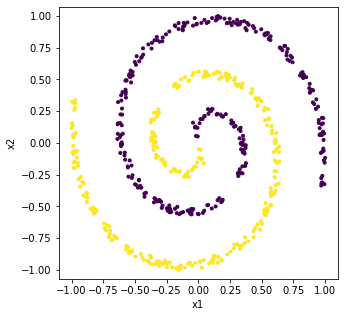

In [6]:
x, y = twospirals(300, angle=560)
x, y = x/x.max(axis=0, keepdims=True), y.reshape(-1)
xx, yy = torch.FloatTensor(x), torch.FloatTensor(y.reshape(-1,1))

x1 = xx[:,0]
x2 = xx[:,1]

%matplotlib inline
plt.figure(figsize=(5,5))
plt.scatter(x1, x2, c=y, marker='.')
# plt.savefig("./clf_toy_data.pdf")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.show()

In [7]:
xx, yy = xx.to(device), yy.to(device)

In [8]:
class SoftmaxTemp(nn.Module):
    def __init__(self, temp=3.0):
        super().__init__()
        self.temp = temp
        
    def forward(self, x):
        return torch.softmax(x*self.temp, dim=-1)

In [9]:
class ResidualMLP(nn.Module):
    
    def __init__(self, h):
        super().__init__()
        self.net = nn.Sequential(
#             dtnn.DistanceTransformBase(2, h),
            dtnn.DistanceTransform(2, h),
            nn.Sequential(dtnn.ScaleShift(h, scale_init=10, shift_init=None), ### Shift is learnable, scale is fixed
                            nn.Softmax(dim=-1)),
#             dtnn.DistanceTransform_MinExp(2, h, bias=False),
#             SoftmaxTemp(10.0),
#             nn.BatchNorm1d(h),
#             nn.ELU(),
#             dtnn.OneActiv(h, mode="relu"),
            dtnn.OneActiv(h, mode="exp_1.6"),
            nn.Linear(h, 2),
            )
        self.net[0].centers.data = torch.randn_like(self.net[0].centers)/3.
        self.clf = nn.Linear(2, 1)
        
    def forward(self, x):
        return torch.sigmoid(self.clf(x + self.net(x)))
#         return torch.sigmoid(self.clf(self.net(x)))

In [10]:
net = ResidualMLP(10).to(device)
# optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)

criterion = nn.BCELoss()
# criterion = nn.MSELoss()

_________________________
Epoch: 99, Acc:0.58, Loss:0.6939525008201599
Epoch: 199, Acc:0.59, Loss:0.6895517110824585
Epoch: 299, Acc:0.58, Loss:0.6854588389396667
Epoch: 399, Acc:0.56, Loss:0.681646466255188
Epoch: 499, Acc:0.57, Loss:0.6780902147293091
Epoch: 599, Acc:0.57, Loss:0.6747682094573975
Epoch: 699, Acc:0.57, Loss:0.6716606616973877
Epoch: 799, Acc:0.57, Loss:0.6687497496604919
Epoch: 899, Acc:0.57, Loss:0.666019082069397
Epoch: 999, Acc:0.60, Loss:0.6634535789489746


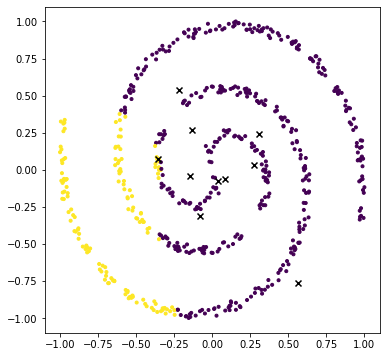

Epoch: 1099, Acc:0.61, Loss:0.661039412021637
Epoch: 1199, Acc:0.61, Loss:0.6587634086608887
Epoch: 1299, Acc:0.60, Loss:0.6566134691238403
Epoch: 1399, Acc:0.60, Loss:0.6545782685279846
Epoch: 1499, Acc:0.60, Loss:0.6526467800140381
Epoch: 1599, Acc:0.60, Loss:0.6508089900016785
Epoch: 1699, Acc:0.61, Loss:0.649055004119873
Epoch: 1799, Acc:0.60, Loss:0.6473755240440369
Epoch: 1899, Acc:0.62, Loss:0.6457617282867432
Epoch: 1999, Acc:0.62, Loss:0.6442053318023682


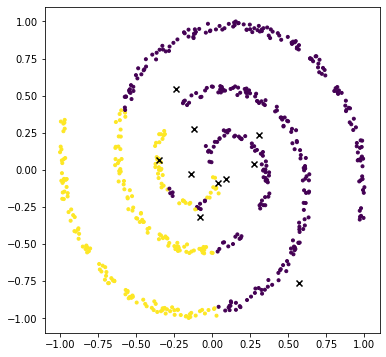

Epoch: 2099, Acc:0.63, Loss:0.6426986455917358
Epoch: 2199, Acc:0.64, Loss:0.6412346363067627
Epoch: 2299, Acc:0.65, Loss:0.6398073434829712
Epoch: 2399, Acc:0.65, Loss:0.6384117603302002
Epoch: 2499, Acc:0.65, Loss:0.6370441913604736
Epoch: 2599, Acc:0.65, Loss:0.6357022523880005
Epoch: 2699, Acc:0.65, Loss:0.6343844532966614
Epoch: 2799, Acc:0.65, Loss:0.6330904960632324
Epoch: 2899, Acc:0.65, Loss:0.6318206787109375
Epoch: 2999, Acc:0.65, Loss:0.6305756568908691


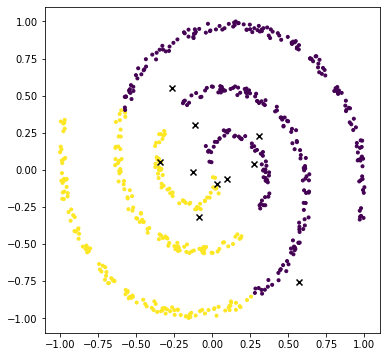

Epoch: 3099, Acc:0.65, Loss:0.6293560862541199
Epoch: 3199, Acc:0.65, Loss:0.6281624436378479
Epoch: 3299, Acc:0.65, Loss:0.6269948482513428
Epoch: 3399, Acc:0.65, Loss:0.6258531808853149
Epoch: 3499, Acc:0.66, Loss:0.6247369647026062
Epoch: 3599, Acc:0.66, Loss:0.6236454248428345
Epoch: 3699, Acc:0.66, Loss:0.6225775480270386
Epoch: 3799, Acc:0.66, Loss:0.6215322017669678
Epoch: 3899, Acc:0.66, Loss:0.6205081343650818
Epoch: 3999, Acc:0.66, Loss:0.6195041537284851


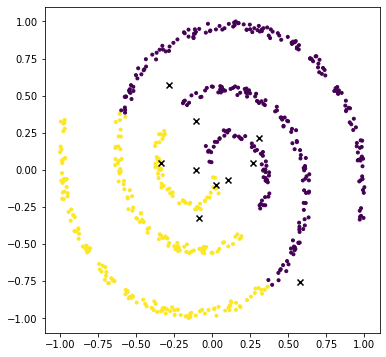

Epoch: 4099, Acc:0.67, Loss:0.6185189485549927
Epoch: 4199, Acc:0.67, Loss:0.6175512671470642
Epoch: 4299, Acc:0.67, Loss:0.6165999174118042
Epoch: 4399, Acc:0.67, Loss:0.6156636476516724
Epoch: 4499, Acc:0.67, Loss:0.6147414445877075
Epoch: 4599, Acc:0.67, Loss:0.6138320565223694
Epoch: 4699, Acc:0.67, Loss:0.6129347085952759
Epoch: 4799, Acc:0.67, Loss:0.612048327922821
Epoch: 4899, Acc:0.67, Loss:0.6111723780632019
Epoch: 4999, Acc:0.67, Loss:0.610305905342102


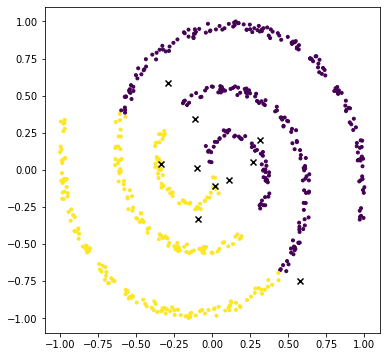

In [11]:
print("_________________________")
for epoch in range(5000):
    yout = net(xx)
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1)%100 == 0:
        accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()                
        print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

    if (epoch+1)%1000 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot()
        out = (yout.data.cpu().numpy()>0.5).astype(int)
        ax.scatter(x1, x2, c=out, marker= '.')
        ## plot centroids
        c = net.net[0].centers.data.cpu()
        ax.scatter(c[:,0], c[:,1], color='k', marker= 'x')
        plt.show()

In [12]:
xx.device

device(type='cuda', index=0)

In [13]:
net.net[:-1]

Sequential(
  (0): DistanceTransform()
  (1): Sequential(
    (0): ScaleShift()
    (1): Softmax(dim=-1)
  )
  (2): OneActiv()
)

(array([  3.,   3.,  13.,  13.,  14.,  20.,  17.,  23.,  33., 461.]),
 array([0.63392764, 0.67053485, 0.7071421 , 0.7437494 , 0.7803566 ,
        0.8169638 , 0.85357106, 0.8901783 , 0.9267855 , 0.96339273,
        1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

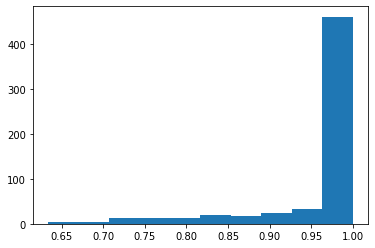

In [14]:
maxvals = net.net[:-1](xx).data.cpu().max(dim=1)[0]
plt.hist(maxvals)

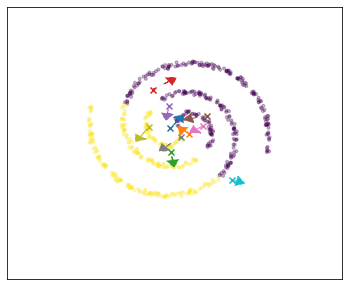

In [15]:
yout = net(xx)
ax = plt.figure(figsize=(6,5)).add_subplot()
out = (yout.data.cpu().numpy()>0.5).astype(int)
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = net.net[0].centers.data.cpu()
d = net.net[-1].weight.data.cpu().t()*0.5 #+ net.net[-1].bias.data.cpu()


for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i)
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')
    
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)

# plt.savefig("./outputs/01.0_viz_clf_vector_0.pdf", bbox_inches='tight')
plt.show()

In [16]:
net.net[-1].weight.data.cpu().t() + net.net[-1].bias.data.cpu()

tensor([[ 0.2383,  0.2382],
        [-0.0415,  0.0888],
        [ 0.1016, -0.2373],
        [ 0.4090,  0.2372],
        [ 0.0284, -0.2169],
        [-0.2700, -0.0767],
        [-0.0703, -0.0898],
        [-0.2697, -0.2940],
        [-0.1142, -0.2758],
        [ 0.1630, -0.0240]])

In [17]:
net.net[1][0].shifter

Parameter containing:
tensor([[0.9999, 0.9999, 1.0005, 0.9998, 1.0025, 0.9981, 0.9999, 1.0002, 0.9997,
         0.9996]], device='cuda:0', requires_grad=True)

## Actively choosing Data points as weights (w.r.t. SGD)

In [18]:
def directional_similarity(point, direction, other_points):
    '''
    Calculates directional similarity
    point -> [m, dim]: point from which direction is found 
    direction -> [m, dim]: un-normalized direction in which to find similarity; OR negative gradient
    other_points -> [N, dim]: other valid points to find the direction
    '''
    
#     print(point.shape)
#     print(direction.shape)
#     print(other_points.shape)
    
    
    ### direction towards +ve x-axis
    direction = direction/torch.norm(direction, p=1, dim=-1, keepdim=True) ## always normalized

    vecs = other_points.unsqueeze(0)-point.unsqueeze(1)
    vecs_mag = torch.norm(vecs, p=1.5, dim=-1, keepdim=True)
    vecs_dirn = vecs/(vecs_mag+1e-11) ## 1e-B for stability
    
#     print(vecs_dirn.shape, direction.unsqueeze(2).shape)
#     yout = vecs_dirn@direction.t() ## gives importance to direction
    yout = torch.bmm(vecs_dirn, direction.unsqueeze(2))## gives importance to direction
#     print(yout.shape, vecs_mag.shape)
    yout = yout/(vecs_mag+1e-11+1) ## gives inportance to similarity
    return yout

In [19]:
num_points = 100
X1 = np.linspace(-1.0, 1.0, num_points)
X2 = np.linspace(0.0, 2.0, num_points)

# X1 = np.linspace(-0.6, -0.4, num_points)
# X2 = np.linspace(0.9, 1.1, num_points)

X1, X2 = np.meshgrid(X1, X2)

XX_grid = torch.Tensor(np.c_[X1.reshape(-1), X2.reshape(-1)])

In [20]:
point = torch.Tensor([[-0.5, 1]])
direction = torch.Tensor([[1, 0]])

In [21]:
sim = directional_similarity(point, direction, XX_grid)

In [22]:
## reduce output variance
# sim = (sim.abs() ** (1/10)) *sim.sign()

tensor([-0.4343,  1.0101])


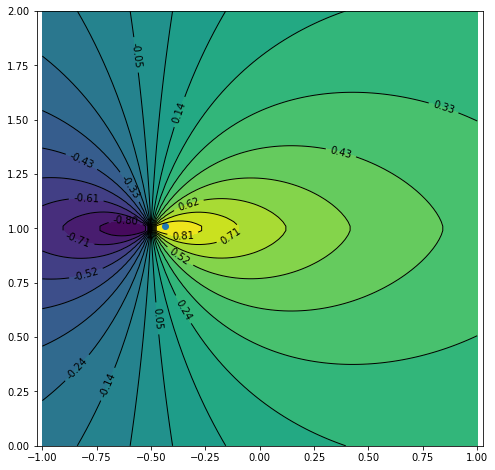

In [23]:
%matplotlib inline
LVLs = np.linspace(sim.min(), sim.max(), 20)

plt.figure(figsize=(8,8))
plt.contourf(X1, X2, sim.data.numpy().reshape(X1.shape), levels=LVLs)
cs = plt.contour(X1, X2, sim.data.numpy().reshape(X1.shape), levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")

xx_max = XX_grid[sim.argmax()]
plt.scatter(*xx_max)
plt.axis('equal')
print(xx_max)

In [24]:
class ResidualMLP(nn.Module):
    
    def __init__(self, h):
        super().__init__()
        self.net = nn.Sequential(
#             dtnn.DistanceTransformBase(2, h),
            dtnn.DistanceTransform(2, h),
            nn.Sequential(dtnn.ScaleShift(h, scale_init=10, shift_init=None), ### Shift is learnable, scale is fixed
                            nn.Softmax(dim=-1)),
            dtnn.OneActiv(h, mode="exp_1.6"),
            nn.Linear(h, 2),
            )
        self.net[0].centers.data = torch.randn_like(self.net[0].centers)/3.
        self.clf = nn.Linear(2, 1)
        
    def forward(self, x):
        return torch.sigmoid(self.clf(x + self.net(x)))
#         return torch.sigmoid(self.clf(self.net(x)))

In [25]:
net = ResidualMLP(10).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = nn.BCELoss()
# criterion = nn.MSELoss()

In [26]:
net.net[0].centers.shape

torch.Size([10, 2])

_________________________
Epoch: 99, Acc:0.50, Loss:0.6958243250846863
Epoch: 199, Acc:0.63, Loss:0.6720619797706604
Epoch: 299, Acc:0.67, Loss:0.6524479389190674
Epoch: 399, Acc:0.67, Loss:0.6326462030410767
Epoch: 499, Acc:0.67, Loss:0.6109068989753723
Epoch: 599, Acc:0.67, Loss:0.5880202651023865
Epoch: 699, Acc:0.71, Loss:0.5657753348350525
Epoch: 799, Acc:0.71, Loss:0.546644926071167
Epoch: 899, Acc:0.71, Loss:0.5318950414657593
Epoch: 999, Acc:0.72, Loss:0.5205821990966797


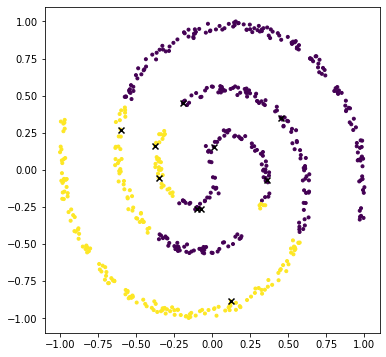

Epoch: 1099, Acc:0.72, Loss:0.5263992547988892
Epoch: 1199, Acc:0.73, Loss:0.5020416378974915
Epoch: 1299, Acc:0.74, Loss:0.47659191489219666
Epoch: 1399, Acc:0.75, Loss:0.4487835764884949
Epoch: 1499, Acc:0.78, Loss:0.41952070593833923
Epoch: 1599, Acc:0.80, Loss:0.39325252175331116
Epoch: 1699, Acc:0.80, Loss:0.3739530146121979
Epoch: 1799, Acc:0.84, Loss:0.3601519465446472
Epoch: 1899, Acc:0.87, Loss:0.34941744804382324
Epoch: 1999, Acc:0.89, Loss:0.34073522686958313


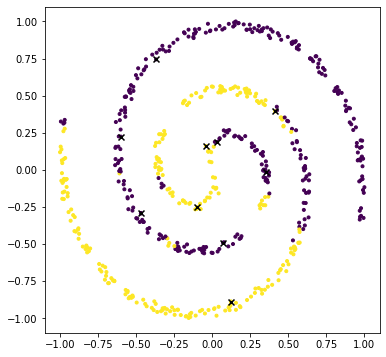

Epoch: 2099, Acc:0.79, Loss:0.5062466263771057
Epoch: 2199, Acc:0.79, Loss:0.4764062762260437
Epoch: 2299, Acc:0.79, Loss:0.45235148072242737
Epoch: 2399, Acc:0.80, Loss:0.4333520531654358
Epoch: 2499, Acc:0.80, Loss:0.4182797372341156
Epoch: 2599, Acc:0.81, Loss:0.4061223566532135
Epoch: 2699, Acc:0.81, Loss:0.39623674750328064
Epoch: 2799, Acc:0.81, Loss:0.38809287548065186
Epoch: 2899, Acc:0.80, Loss:0.38116389513015747
Epoch: 2999, Acc:0.80, Loss:0.37504714727401733


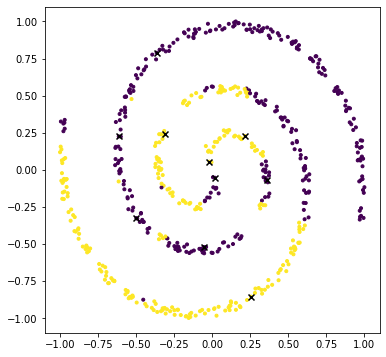

Epoch: 3099, Acc:0.70, Loss:0.7797231078147888
Epoch: 3199, Acc:0.69, Loss:0.6993358731269836
Epoch: 3299, Acc:0.67, Loss:0.6304776072502136
Epoch: 3399, Acc:0.67, Loss:0.5819270014762878
Epoch: 3499, Acc:0.67, Loss:0.5493729710578918
Epoch: 3599, Acc:0.68, Loss:0.5266407132148743
Epoch: 3699, Acc:0.68, Loss:0.5103719234466553
Epoch: 3799, Acc:0.69, Loss:0.4982854425907135
Epoch: 3899, Acc:0.71, Loss:0.4890217185020447
Epoch: 3999, Acc:0.71, Loss:0.48184138536453247


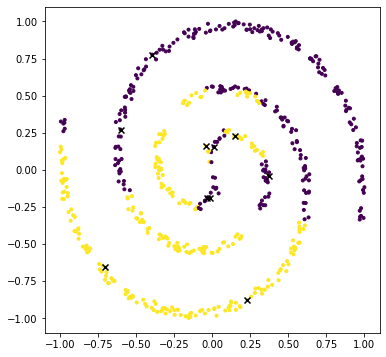

Epoch: 4099, Acc:0.78, Loss:0.48828592896461487
Epoch: 4199, Acc:0.81, Loss:0.4498313367366791
Epoch: 4299, Acc:0.84, Loss:0.4172605574131012
Epoch: 4399, Acc:0.85, Loss:0.39246174693107605
Epoch: 4499, Acc:0.85, Loss:0.37373679876327515
Epoch: 4599, Acc:0.86, Loss:0.35833540558815
Epoch: 4699, Acc:0.87, Loss:0.34492918848991394
Epoch: 4799, Acc:0.88, Loss:0.33308112621307373
Epoch: 4899, Acc:0.88, Loss:0.32269486784935
Epoch: 4999, Acc:0.88, Loss:0.31351155042648315


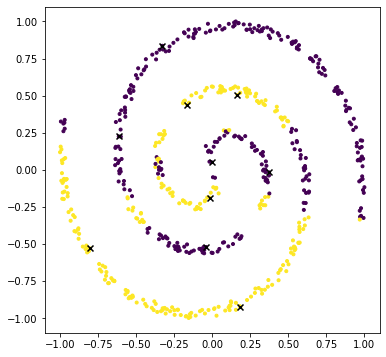

In [27]:
print("_________________________")
for epoch in range(5000):
    yout = net(xx)
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    ########################################################
    ### Do discrete optimization here
    if (epoch+0)%1000 == 0:
        sim = directional_similarity(
                    net.net[0].centers, 
                    -net.net[0].centers.grad, 
                    xx).squeeze(-1)
    #     print(sim.shape)

        sim_x = sim.argmax(dim=-1)
    #     print(sim_x)
    #     print(xx[sim_x])
        net.net[0].centers.data = xx[sim_x]
    
#     break
    ########################################################
        optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    else:
        net.net[0].centers.grad = None
        optimizer.step()

    if (epoch+1)%100 == 0:
        accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()                
        print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

    if (epoch+1)%1000 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot()
        out = (yout.data.cpu().numpy()>0.5).astype(int)
        ax.scatter(x1, x2, c=out, marker= '.')
        ## plot centroids
        c = net.net[0].centers.data.cpu()
        ax.scatter(c[:,0], c[:,1], color='k', marker= 'x')
        plt.show()

## Visualize the optimization Step by Step.
#### Try 1. Optimize centers once - Optimize Linear Layer a few steps (with new Optimizer)

In [32]:
net = ResidualMLP(10).to(device)
criterion = nn.BCELoss()

#### Optimize Center

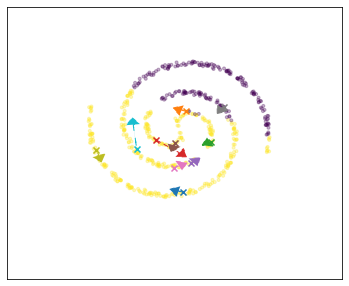

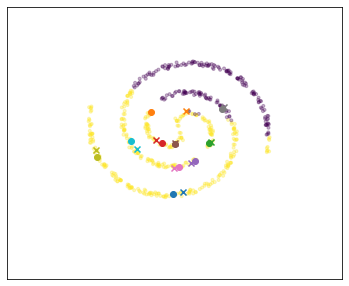

In [105]:
yout = net(xx)
loss = criterion(yout, yy)

optimizer.zero_grad()
loss.backward()
#####################################################
### Visualize directional Similarity

ax = plt.figure(figsize=(6,5)).add_subplot()
out = (yout.data.cpu().numpy()>0.5).astype(int)
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = net.net[0].centers.data.cpu()
d = -net.net[0].centers.grad.data.cpu()*10


for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i)
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)
plt.show()

old_centers = net.net[0].centers.data.cpu().numpy()

########################################################
### Do discrete optimization here
sim = directional_similarity(
            net.net[0].centers, 
            -net.net[0].centers.grad, 
            xx).squeeze(-1)

sim_x = sim.argmax(dim=-1)
# print(sim_x)
net.net[0].centers.data = xx[sim_x]
########################################################

ax = plt.figure(figsize=(6,5)).add_subplot()
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = net.net[0].centers.data.cpu()
oc = old_centers
for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i)
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'o')
    ax.scatter(oc[i,0], oc[i,1], color=color, marker= 'x')
    

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)
plt.show()

#### Optimize Rest

In [89]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

In [92]:
for i in range(1000):
    yout = net(xx)
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    net.net[0].centers.grad = None
    optimizer.step()
    
    if i%100 == 0:
        accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()                
        print(f'Epoch: {i}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

Epoch: 0, Acc:0.86, Loss:0.4418491721153259
Epoch: 100, Acc:0.86, Loss:0.43263086676597595
Epoch: 200, Acc:0.87, Loss:0.4256841242313385
Epoch: 300, Acc:0.86, Loss:0.41952255368232727
Epoch: 400, Acc:0.87, Loss:0.4129579961299896
Epoch: 500, Acc:0.87, Loss:0.4077983796596527
Epoch: 600, Acc:0.87, Loss:0.40280452370643616
Epoch: 700, Acc:0.87, Loss:0.39965155720710754
Epoch: 800, Acc:0.87, Loss:0.3977832496166229
Epoch: 900, Acc:0.87, Loss:0.39618444442749023


#### Output

Epoch: 4999, Acc:0.86, Loss:0.4419591426849365


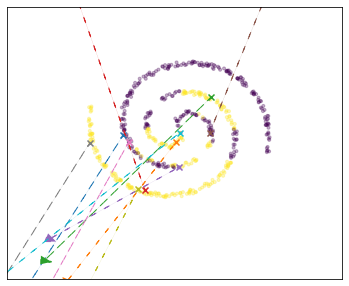

In [91]:
accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()                
print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

with torch.no_grad():
    yout = net(xx)
ax = plt.figure(figsize=(6,5)).add_subplot()
out = (yout.data.cpu().numpy()>0.5).astype(int)
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = net.net[0].centers.data.cpu()
d = net.net[-1].weight.data.cpu().t() #+ net.net[-1].bias.data.cpu()


for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i)
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)
plt.show()

#### Directional Similarity Based On Gradient Magnitude

In [477]:
def directional_similarity_mag(point, direction, other_points):
    '''
    Calculates directional similarity
    point -> [m, dim]: point from which direction is found 
    direction -> [m, dim]: un-normalized direction in which to find similarity; OR negative gradient
    other_points -> [N, dim]: other valid points to find the direction
    '''
    
#     print(point.shape)
#     print(direction.shape)
#     print(other_points.shape)
    
#     C = torch.Tensor([[0]]).to(point.device)
    C = torch.norm(direction, p=2, dim=-1, keepdim=True)
#     print(C.shape)
    C = C.unsqueeze(1)
    
    ### direction towards +ve x-axis
#     direction = direction/torch.norm(direction, p=1, dim=-1, keepdim=True) ## always normalized
    vecs = other_points.unsqueeze(0)-point.unsqueeze(1)
    vecs_mag = torch.norm(vecs, p=2, dim=-1, keepdim=True)
#     print(vecs.shape, vecs_mag.shape, C.shape)
    vecs_dirn = vecs/(vecs_mag+1e-11+C) ## 1e-B for stability
    
#     print(vecs_dirn.shape, direction.unsqueeze(2).shape)
#     yout = vecs_dirn@direction.t() ## gives importance to direction
    yout = torch.bmm(vecs_dirn, direction.unsqueeze(2))## gives importance to direction
#     print(yout.shape, vecs_mag.shape)
    yout = yout/(vecs_mag+1e-11+C) ## gives inportance to similarity
    return yout.squeeze(-1)

In [482]:
point = torch.Tensor([[-0.5, 1]])
direction = torch.Tensor([[1, 0]])*0.05

In [483]:
sim = directional_similarity_mag(point, direction, XX_grid)

In [484]:
## reduce output variance
# sim = (sim.abs() ** (1/10)) *sim.sign()

tensor([-0.4545,  1.0101])


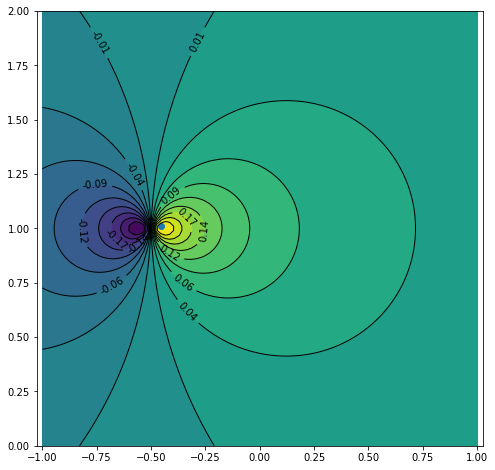

In [485]:
%matplotlib inline
LVLs = np.linspace(sim.min(), sim.max(), 20)

plt.figure(figsize=(8,8))
plt.contourf(X1, X2, sim.data.numpy().reshape(X1.shape), levels=LVLs)
cs = plt.contour(X1, X2, sim.data.numpy().reshape(X1.shape), levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")

xx_max = XX_grid[sim.argmax()]
plt.scatter(*xx_max)
plt.axis('equal')
print(xx_max)

In [381]:
class ResidualMLP(nn.Module):
    
    def __init__(self, h, scale=10):
        super().__init__()
        self.net = nn.Sequential(
#             dtnn.DistanceTransformBase(2, h),
            dtnn.DistanceTransform(2, h),
            nn.Sequential(dtnn.ScaleShift(h, scale_init=scale, shift_init=None), ### Shift is learnable, scale is fixed
                            nn.Softmax(dim=-1)),
            dtnn.OneActiv(h, mode="exp_1.6"),
            nn.Linear(h, 2),
            )
        self.net[0].centers.data = torch.randn_like(self.net[0].centers)/3.
        self.clf = nn.Linear(2, 1)
        
    def forward(self, x):
        return torch.sigmoid(self.clf(x + self.net(x)))
#         return torch.sigmoid(self.clf(self.net(x)))

## Visualize the optimization Step by Step.
#### Try 1. Optimize centers once - Optimize Linear Layer a few steps (with new Optimizer)

In [410]:
net = ResidualMLP(10).to(device)
criterion = nn.BCELoss()

#### Optimize Center

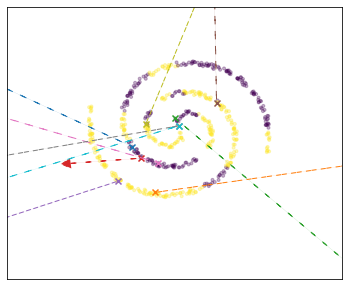

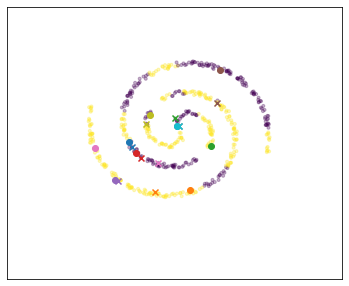

In [416]:
LR = 0.1

yout = net(xx)
loss = criterion(yout, yy)

optimizer.zero_grad()
loss.backward()
#####################################################
### Visualize directional Similarity

ax = plt.figure(figsize=(6,5)).add_subplot()
out = (yout.data.cpu().numpy()>0.5).astype(int)
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = net.net[0].centers.data.cpu()
d = -net.net[0].centers.grad.data.cpu()*10


for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i)
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)
plt.show()

old_centers = net.net[0].centers.data.cpu().numpy()

########################################################
### Do discrete optimization here
sim = directional_similarity_mag(
            net.net[0].centers, 
            -net.net[0].centers.grad * LR, 
            xx)

sim_x = sim.argmax(dim=-1)
net.net[0].centers.data = xx[sim_x]
########################################################

ax = plt.figure(figsize=(6,5)).add_subplot()
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = net.net[0].centers.data.cpu()
oc = old_centers
for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i)
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'o')
    ax.scatter(oc[i,0], oc[i,1], color=color, marker= 'x')
    

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)
plt.show()

#### Optimize Rest

In [417]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

In [418]:
for i in range(1000):
    yout = net(xx)
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    net.net[0].centers.grad = None
    optimizer.step()
    
    if i%100 == 0:
        accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()                
        print(f'Epoch: {i}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

Epoch: 0, Acc:0.68, Loss:3.544259548187256
Epoch: 100, Acc:0.74, Loss:0.6340029835700989
Epoch: 200, Acc:0.78, Loss:0.5214241743087769
Epoch: 300, Acc:0.81, Loss:0.47299307584762573
Epoch: 400, Acc:0.83, Loss:0.4404967725276947
Epoch: 500, Acc:0.83, Loss:0.40991246700286865
Epoch: 600, Acc:0.85, Loss:0.39567530155181885
Epoch: 700, Acc:0.84, Loss:0.389445960521698
Epoch: 800, Acc:0.84, Loss:0.3859931528568268
Epoch: 900, Acc:0.84, Loss:0.38399186730384827


#### Output

Epoch: 9999, Acc:0.88, Loss:0.27625373005867004


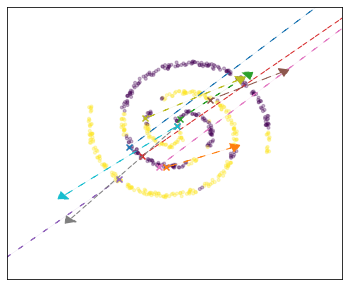

In [414]:
accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()                
print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

with torch.no_grad():
    yout = net(xx)
ax = plt.figure(figsize=(6,5)).add_subplot()
out = (yout.data.cpu().numpy()>0.5).astype(int)
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = net.net[0].centers.data.cpu()
d = net.net[-1].weight.data.cpu().t() #+ net.net[-1].bias.data.cpu()


for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i)
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)
plt.show()

## Train At Once

In [468]:
class ResidualMLP(nn.Module):
    
    def __init__(self, h, scale=10):
        super().__init__()
        self.net = nn.Sequential(
#             dtnn.DistanceTransformBase(2, h),
            dtnn.DistanceTransform(2, h),
            nn.Sequential(dtnn.ScaleShift(h, scale_init=scale, shift_init=None), ### Shift is learnable, scale is fixed
                            nn.Softmax(dim=-1)),
            dtnn.OneActiv(h, mode="exp_1.6"),
            nn.Linear(h, 2),
            )
        self.net[0].centers.data = torch.randn_like(self.net[0].centers)/3.
        self.clf = nn.Linear(2, 1)
        
    def forward(self, x):
        return torch.sigmoid(self.clf(x + self.net(x)))
#         return torch.sigmoid(self.clf(self.net(x)))

In [469]:
net = ResidualMLP(10, scale=10.0).to(device)

lr = 0.01
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
criterion = nn.BCELoss()
# criterion = nn.MSELoss()
LR = 0.3
min_sim = 0.0

In [470]:
net.net[0].centers.shape, net.net[-1].weight.shape

(torch.Size([10, 2]), torch.Size([2, 10]))

In [471]:
# torch.norm(net.net[-1].weight.data, dim=1, keepdim=True)

Epoch: 99, Acc:0.73, Loss:0.5183758735656738
Epoch: 199, Acc:0.73, Loss:0.457707017660141
Epoch: 299, Acc:0.74, Loss:0.43096575140953064
Epoch: 399, Acc:0.77, Loss:0.41010183095932007
Epoch: 499, Acc:0.83, Loss:0.39127638936042786
Epoch: 599, Acc:0.83, Loss:0.3794163167476654
Epoch: 699, Acc:0.83, Loss:0.3703283667564392
Epoch: 799, Acc:0.81, Loss:0.3653523325920105
Epoch: 899, Acc:0.83, Loss:0.36261770129203796
Epoch: 999, Acc:0.83, Loss:0.36024221777915955


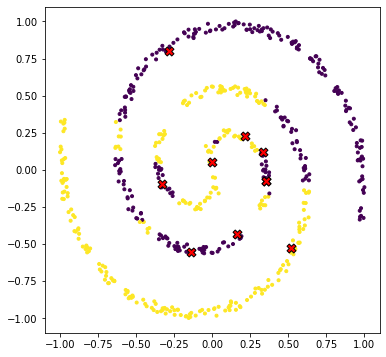

Epoch: 1099, Acc:0.94, Loss:0.26021111011505127
Epoch: 1199, Acc:0.95, Loss:0.20985360443592072
Epoch: 1299, Acc:0.95, Loss:0.1893049031496048
Epoch: 1399, Acc:0.95, Loss:0.17645932734012604
Epoch: 1499, Acc:0.96, Loss:0.16746370494365692
Epoch: 1599, Acc:0.96, Loss:0.16061343252658844
Epoch: 1699, Acc:0.96, Loss:0.15506742894649506
Epoch: 1799, Acc:0.96, Loss:0.15041878819465637
Epoch: 1899, Acc:0.96, Loss:0.14635035395622253
Epoch: 1999, Acc:0.97, Loss:0.14286282658576965


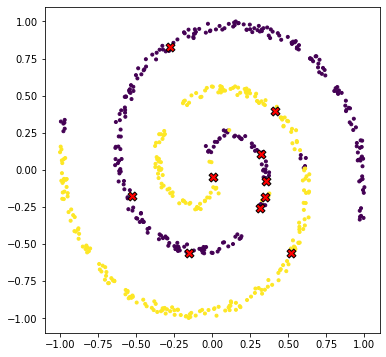

Epoch: 2099, Acc:0.79, Loss:0.437726765871048
Epoch: 2199, Acc:0.87, Loss:0.3647649586200714
Epoch: 2299, Acc:0.88, Loss:0.3363766670227051
Epoch: 2399, Acc:0.88, Loss:0.30353760719299316
Epoch: 2499, Acc:0.88, Loss:0.28869667649269104
Epoch: 2599, Acc:0.89, Loss:0.268797367811203
Epoch: 2699, Acc:0.89, Loss:0.2482268363237381
Epoch: 2799, Acc:0.90, Loss:0.2340908944606781
Epoch: 2899, Acc:0.91, Loss:0.2177242636680603
Epoch: 2999, Acc:0.91, Loss:0.20888957381248474


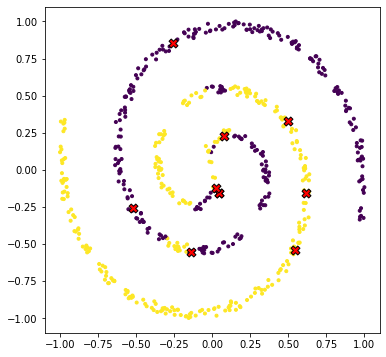

Epoch: 3099, Acc:0.91, Loss:0.21800324320793152
Epoch: 3199, Acc:0.95, Loss:0.15743255615234375
Epoch: 3299, Acc:0.96, Loss:0.12875156104564667
Epoch: 3399, Acc:0.98, Loss:0.10516665875911713
Epoch: 3499, Acc:0.98, Loss:0.08927865326404572
Epoch: 3599, Acc:0.99, Loss:0.07799874246120453
Epoch: 3699, Acc:1.00, Loss:0.06921949237585068
Epoch: 3799, Acc:1.00, Loss:0.06342725455760956
Epoch: 3899, Acc:1.00, Loss:0.05922559276223183
Epoch: 3999, Acc:1.00, Loss:0.055829260498285294


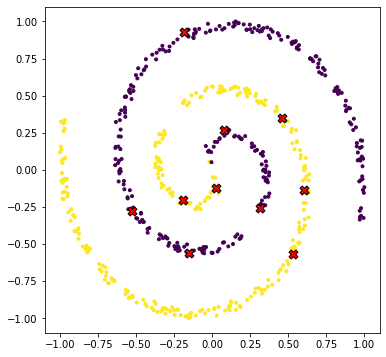

Epoch: 4099, Acc:1.00, Loss:0.04447684809565544
Epoch: 4199, Acc:1.00, Loss:0.04090563580393791
Epoch: 4299, Acc:1.00, Loss:0.03853537514805794
Epoch: 4399, Acc:1.00, Loss:0.03653569519519806
Epoch: 4499, Acc:1.00, Loss:0.03473738953471184
Epoch: 4599, Acc:1.00, Loss:0.03305964171886444
Epoch: 4699, Acc:1.00, Loss:0.03146490454673767
Epoch: 4799, Acc:1.00, Loss:0.029944192618131638
Epoch: 4899, Acc:1.00, Loss:0.02851160429418087
Epoch: 4999, Acc:1.00, Loss:0.02719339355826378


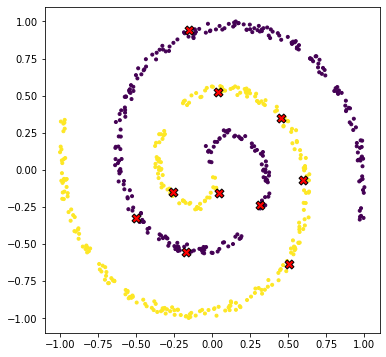

Epoch: 5099, Acc:0.92, Loss:0.23444488644599915
Epoch: 5199, Acc:0.93, Loss:0.1953045278787613
Epoch: 5299, Acc:0.94, Loss:0.17836734652519226
Epoch: 5399, Acc:0.94, Loss:0.17122606933116913
Epoch: 5499, Acc:0.95, Loss:0.1672224998474121
Epoch: 5599, Acc:0.95, Loss:0.1640985906124115
Epoch: 5699, Acc:0.95, Loss:0.16123303771018982
Epoch: 5799, Acc:0.95, Loss:0.15810012817382812
Epoch: 5899, Acc:0.95, Loss:0.154248908162117
Epoch: 5999, Acc:0.95, Loss:0.1499730944633484


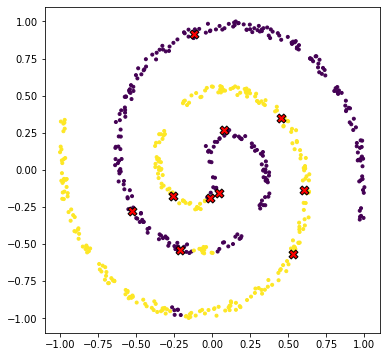

Epoch: 6099, Acc:0.96, Loss:0.2153104990720749
Epoch: 6199, Acc:0.97, Loss:0.18816491961479187
Epoch: 6299, Acc:0.97, Loss:0.17583994567394257
Epoch: 6399, Acc:0.96, Loss:0.1675608605146408
Epoch: 6499, Acc:0.96, Loss:0.1584824174642563
Epoch: 6599, Acc:0.95, Loss:0.14491748809814453
Epoch: 6699, Acc:0.95, Loss:0.13250529766082764
Epoch: 6799, Acc:0.96, Loss:0.1251983642578125
Epoch: 6899, Acc:0.96, Loss:0.11882299184799194
Epoch: 6999, Acc:0.96, Loss:0.11205494403839111


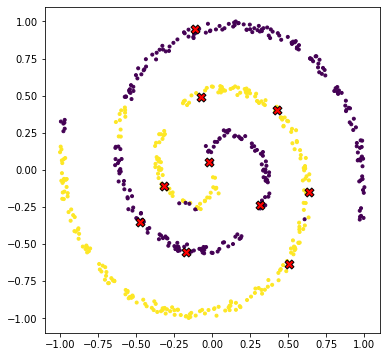

Epoch: 7099, Acc:0.97, Loss:0.08028010278940201
Epoch: 7199, Acc:0.99, Loss:0.06265722960233688
Epoch: 7299, Acc:1.00, Loss:0.054517872631549835
Epoch: 7399, Acc:1.00, Loss:0.04949810728430748
Epoch: 7499, Acc:1.00, Loss:0.046325068920850754
Epoch: 7599, Acc:1.00, Loss:0.04383999481797218
Epoch: 7699, Acc:1.00, Loss:0.041707843542099
Epoch: 7799, Acc:1.00, Loss:0.03981020674109459
Epoch: 7899, Acc:1.00, Loss:0.038089245557785034
Epoch: 7999, Acc:1.00, Loss:0.03651577606797218


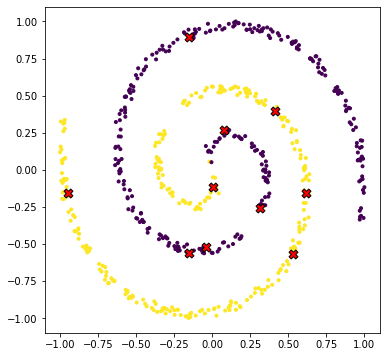

Epoch: 8099, Acc:1.00, Loss:0.025244778022170067
Epoch: 8199, Acc:1.00, Loss:0.023337524384260178
Epoch: 8299, Acc:1.00, Loss:0.022010616958141327
Epoch: 8399, Acc:1.00, Loss:0.021014554426074028
Epoch: 8499, Acc:1.00, Loss:0.02022179588675499
Epoch: 8599, Acc:1.00, Loss:0.01953989639878273
Epoch: 8699, Acc:1.00, Loss:0.01892070472240448
Epoch: 8799, Acc:1.00, Loss:0.018337087705731392
Epoch: 8899, Acc:1.00, Loss:0.017772777006030083
Epoch: 8999, Acc:1.00, Loss:0.017217978835105896


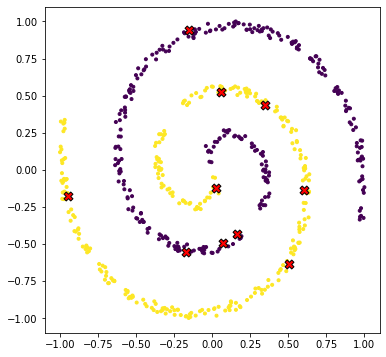

Epoch: 9099, Acc:0.98, Loss:0.08824049681425095
Epoch: 9199, Acc:0.99, Loss:0.03503144532442093
Epoch: 9299, Acc:1.00, Loss:0.02716570906341076
Epoch: 9399, Acc:1.00, Loss:0.025168370455503464
Epoch: 9499, Acc:1.00, Loss:0.023844502866268158
Epoch: 9599, Acc:1.00, Loss:0.022738736122846603
Epoch: 9699, Acc:1.00, Loss:0.021764881908893585
Epoch: 9799, Acc:1.00, Loss:0.02089124172925949
Epoch: 9899, Acc:1.00, Loss:0.020102594047784805
Epoch: 9999, Acc:1.00, Loss:0.021408863365650177


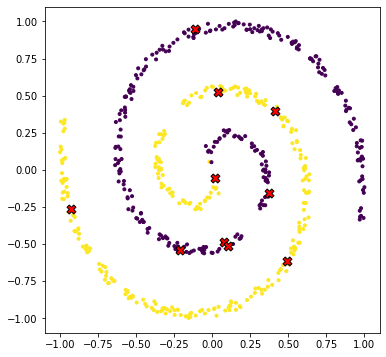

In [472]:
for epoch in range(10000):
    wnorm = torch.norm(net.net[-1].weight.data, dim=0, keepdim=True)
    net.net[-1].weight.data *= wnorm.clamp(0.01, 2.0)/wnorm
    
    yout = net(xx)
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    ########################################################
    ### Do discrete optimization here
    if (epoch+0)%1000 <= 0:
        sim = directional_similarity_mag(
                    net.net[0].centers, 
                    -net.net[0].centers.grad * LR, 
                    xx)
        
        ## Method 1 (no filtering)
        if epoch == 0:
            sim_x = sim.argmax(dim=-1)
            net.net[0].centers.data = xx[sim_x]
        else:
        ## Method 2 (filtering)
            maxval, maxidx = sim.max(dim=-1)
            valid_mask = maxval > min_sim
            net.net[0].centers.data[valid_mask] = xx[maxidx][valid_mask]
    
    ########################################################
#         optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    else:
        net.net[0].centers.grad = None
        optimizer.step()

    if (epoch+1)%100 == 0:
        accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()                
        print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

    if (epoch+1)%1000 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot()
        out = (yout.data.cpu().numpy()>0.5).astype(int)
        ax.scatter(x1, x2, c=out, marker= '.')
        ## plot centroids
        c = net.net[0].centers.data.cpu()
        ax.scatter(c[:,0], c[:,1], facecolor='red', marker= 'X', edgecolor='k', s=80)
        plt.show()

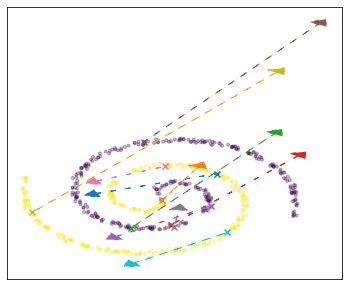

In [475]:
yout = net(xx)
ax = plt.figure(figsize=(6,5)).add_subplot()
out = (yout.data.cpu().numpy()>0.5).astype(int)
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = net.net[0].centers.data.cpu()
d = net.net[-1].weight.data.cpu().t()*1.0 + net.net[-1].bias.data.cpu()


for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i)
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')
    
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
# plt.xlim(-1.9, 1.8)
# plt.ylim(-2.2, 1.8)

# plt.savefig("./outputs/01.0_viz_clf_vector_0.pdf", bbox_inches='tight')
plt.show()

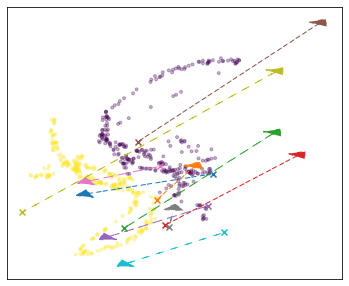

In [476]:
dev = (xx+net.net(xx)*1.0).data.cpu()

ax = plt.figure(figsize=(6,5)).add_subplot()

ax.scatter(dev[:,0], dev[:,1], c=out, marker= '.', alpha=0.3)
## plot centroids
c = net.net[0].centers.data.cpu()
d = net.net[-1].weight.data.cpu().t()*1.0 + net.net[-1].bias.data.cpu()
for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i)
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
# plt.xlim(-1.9, 1.8)
# plt.ylim(-2.2, 1.8)

# plt.savefig("./outputs/01.0_viz_clf_vector_1.pdf", bbox_inches='tight')
plt.show()